In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from ast import literal_eval

In [5]:
# Load dataset
df = pd.read_csv("https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv")

In [7]:
df.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51774 entries, 0 to 51773
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     51774 non-null  object
 1   summaries  51774 non-null  object
 2   terms      51774 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [11]:
df.describe()

,titles,summaries,terms
count,51774,51774,51774
unique,38972,38979,3157
top,Transformers in Vision: A Survey,Astounding results from Transformer models on ...,['cs.CV']
freq,7,7,17369


In [13]:
# Print duplicate values (titles)
duplicate_titles = df[df["titles"].duplicated()]
print(f"Number of duplicate titles: {len(duplicate_titles)}")
print(duplicate_titles)

Number of duplicate titles: 12802
                                                  titles  \
1186      Partial Membership Latent Dirichlet Allocation   
1449   Towards to Robust and Generalized Medical Imag...   
1518   Box-Adapt: Domain-Adaptive Medical Image Segme...   
1530   PoissonSeg: Semi-Supervised Few-Shot Medical I...   
1570   SimCVD: Simple Contrastive Voxel-Wise Represen...   
...                                                  ...   
51737  Graph Convolution: A High-Order and Adaptive A...   
51741  ChemGAN challenge for drug discovery: can AI r...   
51766  Classifying sequences by the optimized dissimi...   
51769  Hierarchically-coupled hidden Markov models fo...   
51773  SparseCodePicking: feature extraction in mass ...   

                                               summaries  \
1186   Topic models (e.g., pLSA, LDA, SLDA) have been...   
1449   To mitigate the radiologist's workload, comput...   
1518   Deep learning has achieved remarkable success ...   
1530 

In [15]:
# Remove duplicate titles
df = df[~df["titles"].duplicated()]

In [17]:
# Group by terms and filter those with more than one occurrence
df_filtered = df.groupby("terms").filter(lambda x: len(x) > 1)
df_filtered["terms"] = df_filtered["terms"].apply(literal_eval)

In [19]:
# Display dataset shape after filtering
print(f"Filtered dataset shape: {df_filtered.shape}")

Filtered dataset shape: (36651, 3)


In [21]:
# Train-test split (90% training, 10% testing)
train_df, test_df = train_test_split(df_filtered, test_size=0.1, stratify=df_filtered["terms"].values)

# 50% of the test set for validation
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

# Display dataset shapes for train, test, and validation splits
print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (32985, 3)
Validation data shape: (1833, 3)
Test data shape: (1833, 3)


In [23]:
# Tokenization and text preprocessing
max_seqlen = 150
text_vectorizer = TextVectorization(max_tokens=20000, output_mode="int", output_sequence_length=max_seqlen)
text_vectorizer.adapt(train_df["summaries"].values)

In [25]:
# String lookup for label binarization
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

In [27]:
# Dataset preparation function
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["summaries"].values, label_binarized))
    dataset = dataset.map(lambda text, label: (text_vectorizer(text), label))
    dataset = dataset.shuffle(1280) if is_train else dataset
    return dataset.batch(128).prefetch(tf.data.AUTOTUNE)

train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [29]:
# Display the number of batches in each dataset
print(f"Number of batches in training dataset: {len(train_dataset)}")
print(f"Number of batches in validation dataset: {len(validation_dataset)}")
print(f"Number of batches in test dataset: {len(test_dataset)}")

Number of batches in training dataset: 258
Number of batches in validation dataset: 15
Number of batches in test dataset: 15


In [31]:
# Improved LSTM Model Definition
def make_lstm_model():
    model = models.Sequential([
        Embedding(input_dim=20000, output_dim=128, mask_zero=True),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(lookup.vocabulary_size(), activation="sigmoid")  # Multi-label classification output
    ])
    return model

In [33]:
# Compile the model
lstm_model = make_lstm_model()
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

In [35]:
# Callbacks for EarlyStopping and Learning Rate Scheduling
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, min_lr=1e-6)

In [37]:
# Train the LSTM model
history = lstm_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 902s 3s/step - binary_accuracy: 0.9560 - loss: 0.1496 - val_binary_accuracy: 0.9894 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 725s 3s/step - binary_accuracy: 0.9888 - loss: 0.0286 - val_binary_accuracy: 0.9894 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 712s 3s/step - binary_accuracy: 0.9891 - loss: 0.0281 - val_binary_accuracy: 0.9894 - val_loss: 0.0267 - learning_rate: 0.0010
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - binary_accuracy: 0.9907 - loss: 0.0259 - val_binary_accuracy: 0.9942 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 744s 3s/step - binary_accuracy: 0.9940 - loss: 0.0207 - val_binary_accuracy: 0.9942 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - binary_accuracy: 0.9943 - loss: 0.0199 - val_binary_accuracy: 0.9942 - val_loss: 0.0195 - learning_rate: 0.001

In [39]:
# Evaluate the model
_, lstm_acc = lstm_model.evaluate(test_dataset)
print(f"LSTM Test Accuracy: {lstm_acc * 100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 712ms/step - binary_accuracy: 0.9941 - loss: 0.0197
LSTM Test Accuracy: 99.42%


In [41]:
# Sample Predictions
sample_texts = [
    "A study on the performance of deep learning models in NLP tasks.",
    "Recent advances in quantum computing algorithms for optimization problems."
]

sample_texts_vectorized = text_vectorizer(sample_texts)
predictions = lstm_model.predict(sample_texts_vectorized)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [43]:
# Sample texts for prediction
sample_texts = [
    "A study on the performance of deep learning models in NLP tasks.",
    "Recent advances in quantum computing algorithms for optimization problems.",
    "Exploring the effectiveness of reinforcement learning in game AI development.",
    "A new approach to convolutional neural networks for image classification.",
    "The impact of artificial intelligence in healthcare decision-making.",
    "Understanding the role of graph neural networks in social network analysis.",
    "Applying transformer models for document summarization and question answering.",
    "The use of generative adversarial networks for realistic image synthesis.",
    "Advancements in cybersecurity using machine learning techniques.",
    "Improving sentiment analysis with large language models and BERT embeddings."
]

# Convert texts to numerical representations
sample_texts_vectorized = text_vectorizer(sample_texts)

# Get model predictions
predictions = lstm_model.predict(sample_texts_vectorized)

# Function to convert predictions to readable labels
def invert_multi_hot(predictions, threshold=0.5, top_k=3):
    """Convert multi-hot predictions to class labels with a threshold."""
    sorted_indices = np.argsort(-predictions)  # Sort in descending order
    return [vocab[i] for i in sorted_indices[:top_k] if predictions[i] >= threshold]

# Print predictions for multiple texts
for i, text in enumerate(sample_texts):
    print(f"Text {i+1}: {text}")
    print(f"LSTM Predictions: {invert_multi_hot(predictions[i])}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Text 1: A study on the performance of deep learning models in NLP tasks.
LSTM Predictions: ['cs.LG', 'stat.ML']
--------------------------------------------------
Text 2: Recent advances in quantum computing algorithms for optimization problems.
LSTM Predictions: ['cs.LG', 'stat.ML']
--------------------------------------------------
Text 3: Exploring the effectiveness of reinforcement learning in game AI development.
LSTM Predictions: ['cs.LG', 'stat.ML']
--------------------------------------------------
Text 4: A new approach to convolutional neural networks for image classification.
LSTM Predictions: ['cs.CV']
--------------------------------------------------
Text 5: The impact of artificial intelligence in healthcare decision-making.
LSTM Predictions: ['cs.LG', 'stat.ML']
--------------------------------------------------
Text 6: Understanding the role of graph neural networks in social network analysis.
LSTM Predictions: ['cs.LG', 'stat.ML']
-

In [45]:
# Plotting training and validation loss/accuracy
def plot_results(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='train_accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

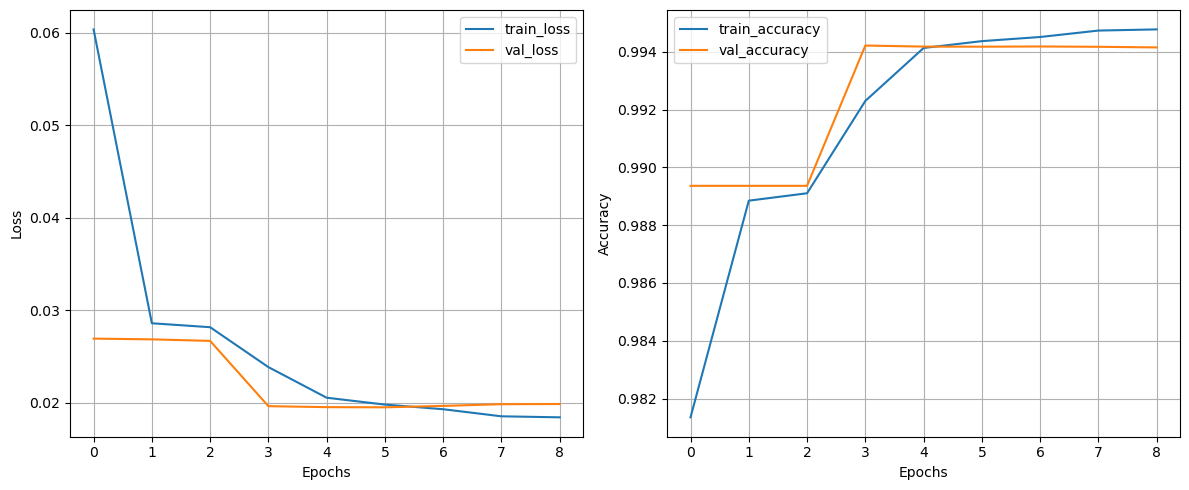

In [47]:
# Call the plot function to visualize the results
plot_results(history)